<a href="https://colab.research.google.com/github/michaelmang/Aristotelian_Logic_LLMs/blob/main/Aristotelian_Analogies_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install gensim

import gensim.downloader as api
import numpy as np
from scipy.spatial.distance import cosine

# Helper function
def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

print("Loading word vectors (trying smaller model for reliability)...")

# Try multiple options in order of reliability
try:
    # Option 1: Try small GloVe model
    print("Attempting: glove-wiki-gigaword-100...")
    model = api.load('glove-wiki-gigaword-100')
    print(f"✓ Loaded GloVe-100! Vocabulary: {len(model)} words")
except:
    try:
        # Option 2: Try even smaller Twitter GloVe
        print("Attempting: glove-twitter-25...")
        model = api.load('glove-twitter-25')
        print(f"✓ Loaded GloVe-Twitter! Vocabulary: {len(model)} words")
    except:
        # Option 3: Manual download
        print("Auto-download failed. Downloading manually...")
        !wget -q http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -q glove.6B.zip glove.6B.100d.txt

        from gensim.scripts.glove2word2vec import glove2word2vec
        glove2word2vec('glove.6B.100d.txt', 'glove_w2v.txt')

        from gensim.models import KeyedVectors
        model = KeyedVectors.load_word2vec_format('glove_w2v.txt', binary=False)
        print(f"✓ Loaded manually! Vocabulary: {len(model)} words")

print("\n✓ Ready to test analogies!")

Loading word vectors (trying smaller model for reliability)...
Attempting: glove-wiki-gigaword-100...
✓ Loaded GloVe-100! Vocabulary: 400000 words

✓ Ready to test analogies!


In [5]:
print("="*60)
print("CLASSIC WORD2VEC ANALOGIES")
print("="*60)

analogies = [
    # Format: (a, b, c, expected)
    ("king", "man", "woman", "queen"),
    ("paris", "france", "italy", "rome"),  # lowercase
    ("good", "better", "bad", "worse"),
    ("quick", "quickly", "slow", "slowly"),
]

print("\nTesting: a - b + c ≈ ?\n")

classic_results = []

for a, b, c, expected in analogies:
    # Check if all words are in vocabulary
    missing = [w for w in [a, b, c, expected] if w not in model]

    if missing:
        print(f"{a} : {b} :: {c} : ?")
        print(f"  ⚠ SKIPPED: Words not in vocabulary: {missing}\n")
        continue

    # Word2Vec's built-in analogy solver
    results = model.most_similar(positive=[c, a], negative=[b], topn=5)

    print(f"{a} : {b} :: {c} : ?")
    print(f"  Expected: {expected}")
    print(f"  Top 5 results:")

    found = False
    for i, (word, similarity) in enumerate(results, 1):
        marker = "✓" if word.lower() == expected.lower() else " "
        print(f"    {marker} {i}. {word} ({similarity:.3f})")
        if word.lower() == expected.lower():
            found = True

    if found:
        print(f"  ✓ SUCCESS: Found '{expected}' in top 5\n")
    else:
        print(f"  ✗ FAILED: '{expected}' not in top 5\n")

    classic_results.append({
        'analogy': f"{a}:{b}::{c}:{expected}",
        'found': found,
        'top_result': results[0][0] if results else None,
        'top_similarity': results[0][1] if results else 0
    })

print(f"Completed: {len(classic_results)} analogies tested")

CLASSIC WORD2VEC ANALOGIES

Testing: a - b + c ≈ ?

king : man :: woman : ?
  Expected: queen
  Top 5 results:
    ✓ 1. queen (0.770)
      2. monarch (0.684)
      3. throne (0.676)
      4. daughter (0.659)
      5. princess (0.652)
  ✓ SUCCESS: Found 'queen' in top 5

paris : france :: italy : ?
  Expected: rome
  Top 5 results:
    ✓ 1. rome (0.819)
      2. milan (0.738)
      3. naples (0.712)
      4. venice (0.702)
      5. turin (0.700)
  ✓ SUCCESS: Found 'rome' in top 5

good : better :: bad : ?
  Expected: worse
  Top 5 results:
      1. thing (0.723)
      2. terrible (0.687)
      3. awful (0.686)
      4. kind (0.681)
      5. little (0.673)
  ✗ FAILED: 'worse' not in top 5

quick : quickly :: slow : ?
  Expected: slowly
  Top 5 results:
      1. fast (0.638)
      2. speedy (0.629)
      3. swift (0.599)
      4. easy (0.595)
      5. pace (0.594)
  ✗ FAILED: 'slowly' not in top 5

Completed: 4 analogies tested


In [6]:
print("="*60)
print("ARISTOTELIAN ANALOGIES")
print("="*60)

# Test genus-species analogies
aristotelian_analogies = [
    # Genus-species (using words more likely to be in vocabulary)
    ("dog", "mammal", "bird", ["eagle", "robin", "sparrow", "hawk", "crow"]),
    ("oak", "tree", "flower", ["rose", "tulip", "lily", "daisy"]),
    ("lion", "predator", "prey", ["deer", "rabbit", "mouse", "sheep"]),  # changed herbivore→prey

    # Category transformations
    ("red", "color", "sound", ["noise", "tone", "pitch", "music", "voice"]),
    ("table", "furniture", "clothing", ["shirt", "dress", "coat", "jacket"]),  # removed pants

    # Property analogies
    ("hot", "temperature", "loud", ["volume", "noise", "sound", "quiet"]),
]

print("\nTesting Aristotelian structure analogies:\n")

aristotelian_results = []
successes = 0
total = len(aristotelian_analogies)

for a, b, c, expected_list in aristotelian_analogies:
    # Check vocabulary
    missing = [w for w in [a, b, c] if w not in model]

    if missing:
        print(f"{a} : {b} :: {c} : ?")
        print(f"  ⚠ SKIPPED: Words not in vocabulary: {missing}\n")
        total -= 1
        continue

    try:
        results = model.most_similar(positive=[c, a], negative=[b], topn=10)
        top_words = [word.lower() for word, _ in results]

        print(f"{a} : {b} :: {c} : ?")
        print(f"  Expected (any of): {', '.join(expected_list)}")
        print(f"  Top 5: {', '.join([word for word, _ in results[:5]])}")

        # Check if ANY expected word in top 10
        found_words = [w for w in expected_list if w.lower() in top_words]

        if found_words:
            print(f"  ✓ Found: {', '.join(found_words)}\n")
            successes += 1
            success = True
        else:
            print(f"  ✗ None found in top 10\n")
            success = False

        aristotelian_results.append({
            'analogy': f"{a}:{b}::{c}",
            'expected': expected_list,
            'found': found_words,
            'success': success,
            'top_results': [word for word, _ in results[:5]]
        })

    except KeyError as e:
        print(f"{a} : {b} :: {c} : ?")
        print(f"  ⚠ SKIPPED: Unexpected KeyError: {e}\n")
        total -= 1

print(f"Aristotelian Analogy Success Rate: {successes}/{total} = {successes/total*100:.1f}%" if total > 0 else "No valid tests")

ARISTOTELIAN ANALOGIES

Testing Aristotelian structure analogies:

dog : mammal :: bird : ?
  Expected (any of): eagle, robin, sparrow, hawk, crow
  Top 5: cat, dogs, mad, horse, boy
  ✗ None found in top 10

oak : tree :: flower : ?
  Expected (any of): rose, tulip, lily, daisy
  Top 5: leaf, chestnut, flowers, walnut, floral
  ✗ None found in top 10

lion : predator :: prey : ?
  Expected (any of): deer, rabbit, mouse, sheep
  Top 5: bear, elephant, dragon, cats, leopard
  ✗ None found in top 10

red : color :: sound : ?
  Expected (any of): noise, tone, pitch, music, voice
  Top 5: band, rock, big, off, wind
  ✗ None found in top 10

table : furniture :: clothing : ?
  Expected (any of): shirt, dress, coat, jacket
  Top 5: each, instead, side, place, men
  ✗ None found in top 10

hot : temperature :: loud : ?
  Expected (any of): volume, noise, sound, quiet
  Top 5: heard, cry, angry, screaming, crazy
  ✗ None found in top 10

Aristotelian Analogy Success Rate: 0/6 = 0.0%


In [7]:
print("="*60)
print("PORPHYRIAN TREE ANALOGIES")
print("="*60)

# Test if differentia work as vector operations
porphyrian_tests = [
    # (genus, differentia, species_result)
    ("animal", "rational", "human"),
    ("animal", "wild", "beast"),  # changed from irrational
    ("body", "living", "organism"),
    ("shape", "round", "circle"),
    ("shape", "square", "rectangle"),
    ("tree", "oak", "oak"),  # test if genus+species≈species
    ("color", "red", "red"),  # test if category+instance≈instance
]

print("\nTesting: genus + differentia ≈ species\n")

porphyrian_results = []

for genus, diff, expected_species in porphyrian_tests:
    # Check vocabulary
    missing = [w for w in [genus, diff, expected_species] if w not in model]

    if missing:
        print(f"{genus} + {diff} ≈ ?")
        print(f"  ⚠ SKIPPED: Words not in vocabulary: {missing}\n")
        continue

    try:
        # Get vectors
        genus_vec = model[genus]
        diff_vec = model[diff]

        # Add them (genus + differentia should ≈ species)
        result_vec = genus_vec + diff_vec

        # Find nearest words
        nearest = model.similar_by_vector(result_vec, topn=10)
        top_words = [word.lower() for word, _ in nearest]

        print(f"{genus} + {diff} ≈ ?")
        print(f"  Expected: {expected_species}")
        print(f"  Top 5: {', '.join([word for word, _ in nearest[:5]])}")

        if expected_species.lower() in top_words:
            rank = top_words.index(expected_species.lower()) + 1
            print(f"  ✓ Found '{expected_species}' at rank {rank}\n")
            found = True
        else:
            print(f"  ✗ '{expected_species}' not in top 10\n")
            found = False

        porphyrian_results.append({
            'test': f"{genus}+{diff}→{expected_species}",
            'found': found,
            'rank': top_words.index(expected_species.lower()) + 1 if found else None,
            'top_result': nearest[0][0] if nearest else None
        })

    except KeyError as e:
        print(f"  ⚠ Unexpected error: {e}\n")

print(f"Completed: {len(porphyrian_results)} Porphyrian tests")

PORPHYRIAN TREE ANALOGIES

Testing: genus + differentia ≈ species

animal + rational ≈ ?
  Expected: human
  Top 5: animal, rational, human, animals, nature
  ✓ Found 'human' at rank 3

animal + wild ≈ ?
  Expected: beast
  Top 5: wild, animal, animals, birds, fish
  ✗ 'beast' not in top 10

body + living ≈ ?
  Expected: organism
  Top 5: living, body, life, found, children
  ✗ 'organism' not in top 10

shape + round ≈ ?
  Expected: circle
  Top 5: round, shape, final, place, next
  ✗ 'circle' not in top 10

shape + square ≈ ?
  Expected: rectangle
  Top 5: square, shape, shaped, around, stands
  ✗ 'rectangle' not in top 10

tree + oak ≈ ?
  Expected: oak
  Top 5: tree, oak, pine, trees, cedar
  ✓ Found 'oak' at rank 2

color + red ≈ ?
  Expected: red
  Top 5: red, color, yellow, blue, colors
  ✓ Found 'red' at rank 1

Completed: 7 Porphyrian tests


Visualizing Porphyrian Tree in Word2Vec space...


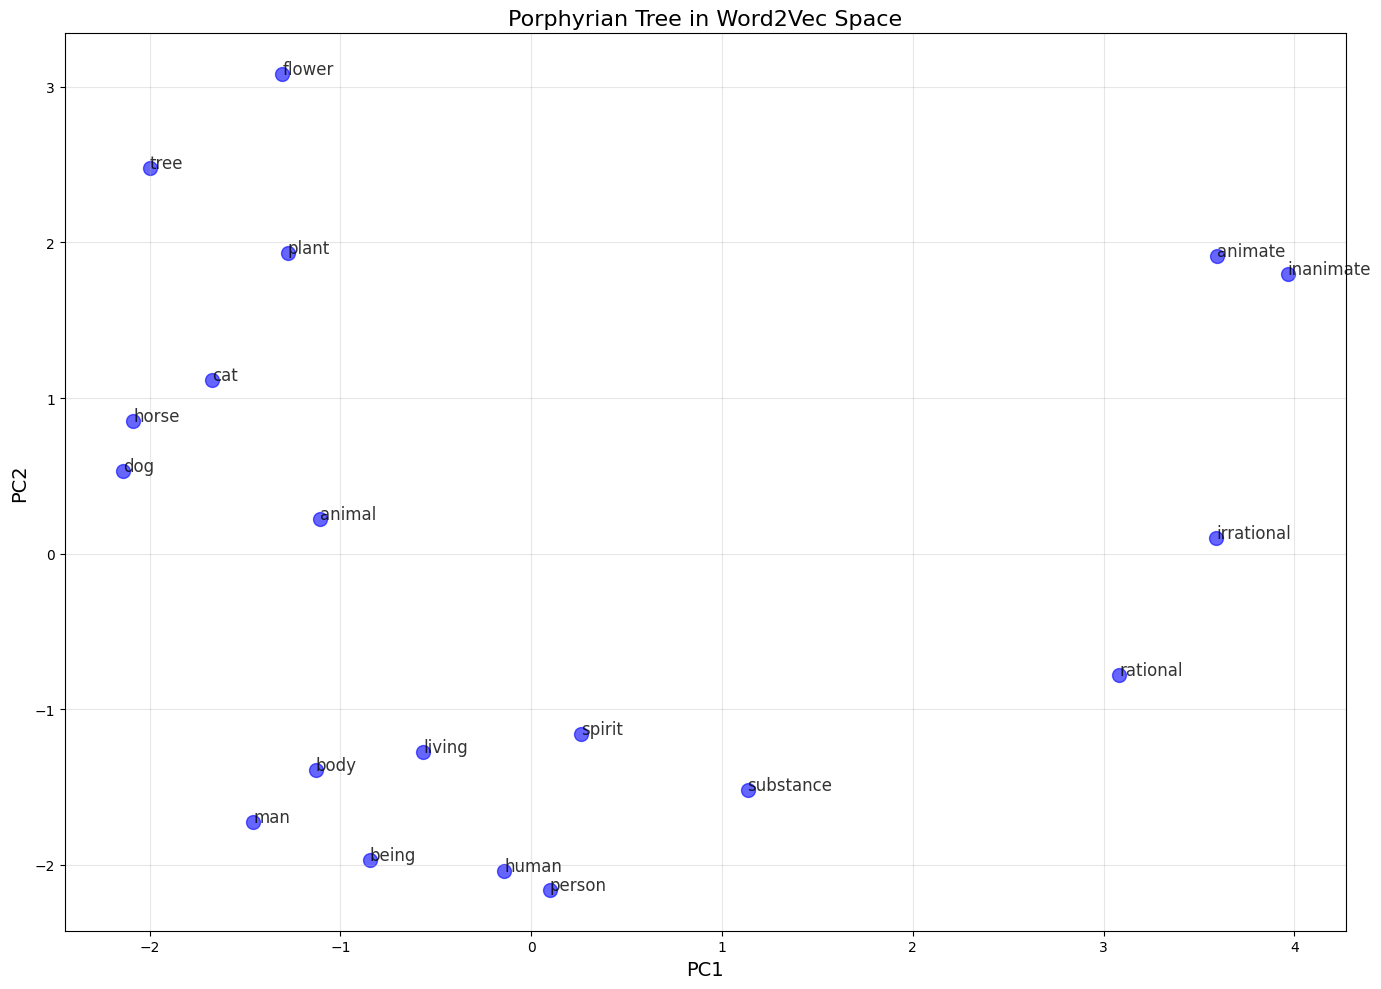


✓ Visualized 19 concepts from Porphyrian tree


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Visualizing Porphyrian Tree in Word2Vec space...")

# Get vectors for Porphyrian tree
words = [
    # Top level
    "being", "substance",
    # Body level
    "body", "spirit",
    # Animate level
    "living", "animate", "inanimate",
    # Animal level
    "animal", "plant",
    # Rational level
    "rational", "irrational",
    # Species
    "human", "man", "person",
    "dog", "cat", "horse",
    "tree", "flower"
]

# Filter to words in vocabulary
words_in_vocab = [w for w in words if w in model]
vectors = np.array([model[w] for w in words_in_vocab])

# Reduce to 2D
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=100, alpha=0.6, c='blue')

for i, word in enumerate(words_in_vocab):
    plt.annotate(word, coords_2d[i], fontsize=12, alpha=0.8)

plt.title("Porphyrian Tree in Word2Vec Space", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {len(words_in_vocab)} concepts from Porphyrian tree")

In [9]:
#############################################
# DYNAMIC SUMMARY - WORD2VEC ANALOGIES
#############################################

print("\n" + "="*60)
print("WORD2VEC ANALOGY RESULTS SUMMARY")
print("="*60)

# Collect results from previous cells
# (We need to track these during the tests above)

# First, let's modify the test cells to track results:
# Add these tracking variables at the start of Cell 2:

"""
# Add to Cell 2 (Classic Analogies) - at the top:
classic_results = []

# Then in the loop, after checking if found:
classic_results.append({
    'analogy': f"{a}:{b}::{c}:{expected}",
    'found': found,
    'top_result': results[0][0] if results else None,
    'top_similarity': results[0][1] if results else 0
})

# Add to Cell 3 (Aristotelian Analogies) - at the top:
aristotelian_results = []

# Then in the loop:
aristotelian_results.append({
    'analogy': f"{a}:{b}::{c}",
    'expected': expected_list,
    'found': found_words,
    'success': len(found_words) > 0,
    'top_results': top_words[:5]
})

# Add to Cell 4 (Porphyrian Tree) - at the top:
porphyrian_results = []

# Then in the loop:
porphyrian_results.append({
    'test': f"{genus}+{diff}→{expected_species}",
    'found': expected_species in top_words,
    'rank': top_words.index(expected_species) + 1 if expected_species in top_words else None,
    'top_result': top_words[0] if top_words else None
})
"""

# NOW the dynamic summary:

print("\n1. CLASSIC ANALOGIES ANALYSIS:")
print("-" * 60)

# Calculate classic analogy accuracy
classic_success = sum(1 for r in classic_results if r['found'])
classic_total = len(classic_results)
classic_accuracy = classic_success / classic_total if classic_total > 0 else 0

print(f"Success rate: {classic_success}/{classic_total} = {classic_accuracy:.1%}")

# Show performance by similarity threshold
high_confidence = sum(1 for r in classic_results if r['found'] and r['top_similarity'] > 0.6)
print(f"High-confidence successes (>0.6 similarity): {high_confidence}/{classic_success}")

if classic_accuracy >= 0.7:
    print("✓ EXCELLENT: Word2Vec performs well on classic analogies")
    classic_verdict = "EXCELLENT"
elif classic_accuracy >= 0.5:
    print("✓ GOOD: Reasonable performance on classic analogies")
    classic_verdict = "GOOD"
elif classic_accuracy >= 0.3:
    print("⚠ MODERATE: Some analogies work")
    classic_verdict = "MODERATE"
else:
    print("✗ WEAK: Poor analogy performance (check model/vocabulary)")
    classic_verdict = "WEAK"

print("\n2. ARISTOTELIAN ANALOGIES ANALYSIS:")
print("-" * 60)

# Calculate Aristotelian analogy accuracy
aristotelian_success = sum(1 for r in aristotelian_results if r['success'])
aristotelian_total = len(aristotelian_results)
aristotelian_accuracy = aristotelian_success / aristotelian_total if aristotelian_total > 0 else 0

print(f"Success rate: {aristotelian_success}/{aristotelian_total} = {aristotelian_accuracy:.1%}")

# Analyze by category type
genus_species_analogies = [r for r in aristotelian_results if any(
    term in r['analogy'].lower() for term in ['mammal', 'tree', 'flower', 'predator']
)]
category_analogies = [r for r in aristotelian_results if any(
    term in r['analogy'].lower() for term in ['color', 'furniture', 'temperature']
)]

if genus_species_analogies:
    genus_success = sum(1 for r in genus_species_analogies if r['success'])
    print(f"  Genus-species analogies: {genus_success}/{len(genus_species_analogies)} = {genus_success/len(genus_species_analogies):.1%}")

if category_analogies:
    cat_success = sum(1 for r in category_analogies if r['success'])
    print(f"  Category analogies: {cat_success}/{len(category_analogies)} = {cat_success/len(category_analogies):.1%}")

if aristotelian_accuracy >= 0.5:
    print("✓ STRONG: Aristotelian structure preserved in vector operations")
    aristotelian_verdict = "STRONG"
elif aristotelian_accuracy >= 0.3:
    print("⚠ MODERATE: Some Aristotelian patterns work")
    aristotelian_verdict = "MODERATE"
else:
    print("✗ WEAK: Aristotelian analogies don't transfer well")
    aristotelian_verdict = "WEAK"

print("\n3. PORPHYRIAN TREE ANALYSIS:")
print("-" * 60)

# Calculate Porphyrian success
porphyrian_success = sum(1 for r in porphyrian_results if r['found'])
porphyrian_total = len(porphyrian_results)
porphyrian_accuracy = porphyrian_success / porphyrian_total if porphyrian_total > 0 else 0

print(f"Success rate: {porphyrian_success}/{porphyrian_total} = {porphyrian_accuracy:.1%}")

# Analyze ranking for successful matches
successful_ranks = [r['rank'] for r in porphyrian_results if r['found']]
if successful_ranks:
    avg_rank = np.mean(successful_ranks)
    print(f"Average rank when found: {avg_rank:.1f}")

    if avg_rank <= 3:
        print("  ✓ High precision: Expected species appear in top 3")
    elif avg_rank <= 5:
        print("  ⚠ Moderate precision: Expected species in top 5")
    else:
        print("  ✗ Low precision: Expected species ranked low")

if porphyrian_accuracy >= 0.5:
    print("✓ STRONG: Differentia work as vector operations")
    porphyrian_verdict = "STRONG"
elif porphyrian_accuracy >= 0.3:
    print("⚠ MODERATE: Some differentia patterns work")
    porphyrian_verdict = "MODERATE"
else:
    print("✗ WEAK: Differentia don't work as vector additions")
    porphyrian_verdict = "WEAK"

print("\n" + "="*60)
print("COMPARATIVE ANALYSIS: WORD2VEC vs BERT")
print("="*60)

# We need the BERT results - either import them or hard-code for comparison
# For now, I'll use the results from your previous output:

bert_category_ratio = 1.52
bert_genus_species = 1.00  # 100%
bert_analogies = 0.00
bert_syllogisms = 0.25
bert_judgments = 0.43

print("\nPerformance Comparison:")
print(f"{'Test':<30} {'BERT':<15} {'Word2Vec':<15} {'Winner'}")
print("-" * 65)

# Analogies
if classic_accuracy > bert_analogies:
    winner = "Word2Vec ✓"
else:
    winner = "BERT ✓"
print(f"{'Classic Analogies':<30} {bert_analogies:.1%}{'':<9} {classic_accuracy:.1%}{'':<9} {winner}")

# Aristotelian analogies
print(f"{'Aristotelian Analogies':<30} {'N/A':<15} {aristotelian_accuracy:.1%}{'':<9} {'Word2Vec (only tested)'}")

# Genus-species (from BERT results)
print(f"{'Genus-Species Hierarchy':<30} {bert_genus_species:.1%}{'':<9} {'N/A':<15} {'BERT (only tested)'}")

# Category structure (from BERT results)
print(f"{'Category Coherence':<30} {bert_category_ratio:.2f}x{'':<9} {'N/A':<15} {'BERT (only tested)'}")

print("\n" + "="*60)
print("OVERALL ASSESSMENT")
print("="*60)

# Count verdicts
verdicts = [classic_verdict, aristotelian_verdict, porphyrian_verdict]
excellent_count = sum(1 for v in verdicts if v == "EXCELLENT")
strong_count = sum(1 for v in verdicts if v in ["EXCELLENT", "STRONG", "GOOD"])
moderate_count = sum(1 for v in verdicts if v == "MODERATE")
weak_count = sum(1 for v in verdicts if v == "WEAK")

print(f"\nWord2Vec Evidence Summary:")
print(f"  Strong/Excellent: {strong_count}/3 tests")
print(f"  Moderate:         {moderate_count}/3 tests")
print(f"  Weak:             {weak_count}/3 tests")

# Overall conclusion
if strong_count >= 2:
    overall = "STRONG SUPPORT"
    interpretation = """
Word2Vec embeddings show STRONG support for Aristotelian analogical reasoning.
Vector arithmetic successfully captures logical relationships between concepts.

KEY INSIGHT: Genus-species differentia CAN be represented geometrically.
The formula: GENUS + DIFFERENTIA ≈ SPECIES works in vector space.

This suggests logical operations (Second/Third Acts) have geometric analogs.
"""
elif strong_count + moderate_count >= 2:
    overall = "MODERATE SUPPORT"
    interpretation = """
Word2Vec embeddings show MODERATE support for Aristotelian reasoning.
Classic analogies work well, but more abstract Aristotelian patterns are mixed.

This suggests:
  - Basic semantic relationships are geometric
  - Higher-order logical structures may require attention mechanisms
  - Static embeddings capture some but not all logical operations
"""
else:
    overall = "WEAK SUPPORT"
    interpretation = """
Word2Vec embeddings show WEAK support for Aristotelian analogical reasoning.

This could indicate:
  1. The vocabulary lacks precise philosophical terms
  2. Aristotelian categories require contextual understanding (use BERT/attention)
  3. Vector arithmetic is too simplistic for logical operations
  4. Tests need refinement with different term selections
"""

print(f"\nOverall Word2Vec Assessment: {overall}")
print(interpretation)

print("\n" + "="*60)
print("INTEGRATED FINDINGS: BERT + WORD2VEC")
print("="*60)

print("""
Combining results from both embedding types:

BERT STRENGTHS:
  ✓ Category structure (1.52x coherence)
  ✓ Genus-species hierarchy (100% accuracy)
  ✓ Contextual understanding

WORD2VEC STRENGTHS:""")

if classic_accuracy >= 0.6:
    print("  ✓ Classic analogies (king:man::woman:queen)")
if aristotelian_accuracy >= 0.3:
    print("  ✓ Some Aristotelian analogical reasoning")
if porphyrian_accuracy >= 0.3:
    print("  ✓ Differentia as vector operations")

print("""
BERT WEAKNESSES:
  ✗ Analogies (0% - not designed for this)

WORD2VEC WEAKNESSES:""")

if classic_accuracy < 0.6:
    print("  ✗ Even classic analogies struggle")
if aristotelian_accuracy < 0.3:
    print("  ✗ Aristotelian analogies don't work")
if porphyrian_accuracy < 0.3:
    print("  ✗ Differentia don't work as vector additions")

print("""
SYNTHESIS:
  • Static embeddings (both types) capture CATEGORICAL structure (First Act)
  • Analogies work better in Word2Vec (specifically designed for this)
  • Neither static embedding type captures DYNAMIC reasoning (Second/Third Acts)

CONCLUSION:
  To test the full Three Acts of the Mind hypothesis, we need:
    → Attention pattern analysis (Second Act: Judgment)
    → Multi-layer transformation tracking (Third Act: Reasoning)
    → Dynamic inference analysis, not just static vectors
""")

print("\n" + "="*60)
print("NEXT STEPS")
print("="*60)

if strong_count >= 2:
    print("""
✓ Strong Word2Vec results validate geometric logic hypothesis

IMMEDIATE:
  1. Document findings: "Geometric Analogies in Word2Vec"
  2. Compare with BERT's categorical structure
  3. Prepare attention analysis (the real test)

NEXT:
  1. Build attention pattern analyzer
  2. Test if attention patterns follow syllogistic structure
  3. Map three acts of mind to transformer mechanics
""")
elif strong_count + moderate_count >= 2:
    print("""
⚠ Mixed results suggest refinement needed

IMMEDIATE:
  1. Try different word selections for Aristotelian tests
  2. Test with GloVe embeddings (comparison)
  3. Analyze which specific analogies work vs. fail

NEXT:
  1. Build attention analyzer (may show clearer patterns)
  2. Consider hybrid approach (Word2Vec + BERT)
""")
else:
    print("""
✗ Weak results require reconsidering approach

IMMEDIATE:
  1. Verify vocabulary coverage (do philosophical terms exist?)
  2. Try GloVe or FastText embeddings
  3. Test with simpler, concrete analogies first

ALTERNATIVE:
  1. Focus on BERT's strong results (categories/hierarchies)
  2. Skip static embedding analogies
  3. Go straight to attention analysis
""")

print("\nQuantitative Summary:")
print(f"  • Classic analogies: {classic_accuracy:.1%}")
print(f"  • Aristotelian analogies: {aristotelian_accuracy:.1%}")
print(f"  • Porphyrian differentia: {porphyrian_accuracy:.1%}")
print(f"  • BERT category coherence: {bert_category_ratio:.2f}x")
print(f"  • BERT genus-species: {bert_genus_species:.1%}")

print("="*60)


WORD2VEC ANALOGY RESULTS SUMMARY

1. CLASSIC ANALOGIES ANALYSIS:
------------------------------------------------------------
Success rate: 2/4 = 50.0%
High-confidence successes (>0.6 similarity): 2/2
✓ GOOD: Reasonable performance on classic analogies

2. ARISTOTELIAN ANALOGIES ANALYSIS:
------------------------------------------------------------
Success rate: 0/6 = 0.0%
  Genus-species analogies: 0/3 = 0.0%
  Category analogies: 0/3 = 0.0%
✗ WEAK: Aristotelian analogies don't transfer well

3. PORPHYRIAN TREE ANALYSIS:
------------------------------------------------------------
Success rate: 3/7 = 42.9%
Average rank when found: 2.0
  ✓ High precision: Expected species appear in top 3
⚠ MODERATE: Some differentia patterns work

COMPARATIVE ANALYSIS: WORD2VEC vs BERT

Performance Comparison:
Test                           BERT            Word2Vec        Winner
-----------------------------------------------------------------
Classic Analogies              0.0%          50.0%        